In [9]:
def sharpe_ratio(rets):
    return rets.mean() / rets.std()

In [10]:
import numpy as np

def positions(x, beta):
    M = len(beta) - 2
    T = len(x)
    Ft = np.zeros(T)
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t - 1]]])
        Ft[t] = np.tanh(np.dot(beta, xt))
    return Ft

In [11]:
def returns(Ft, x, delta):
    T = len(x)
    rets = Ft[0:T - 1] * x[1:T] - delta * np.abs(Ft[1:T] - Ft[0:T - 1])
    return np.concatenate([[0], rets])

In [12]:
def gradient(x, beta, delta):
    Ft = positions(x, beta)
    R = returns(Ft, x, delta)
    T = len(x)
    M = len(beta) - 2
    
    A = np.mean(R)
    B = np.mean(np.square(R))
    S = A / np.sqrt(B - A ** 2)

    dSdA = S * (1 + S ** 2) / A
    dSdB = -S ** 3 / 2 / A ** 2
    dAdR = 1. / T
    dBdR = 2. / T * R
    
    grad = np.zeros(M + 2)  # собственно градиент
    dFpdbeta = np.zeros(M + 2)  # предыдущие значение dFbeta
  
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t-1]]])
        dRdF = -delta * np.sign(Ft[t] - Ft[t-1])
        dRdFp = x[t] + delta * np.sign(Ft[t] - Ft[t-1])
        dFdbeta = (1 - Ft[t] ** 2) * (xt + beta[-1] * dFpdbeta)
        dSdbeta = (dSdA * dAdR + dSdB * dBdR[t]) * (dRdF * dFdbeta + dRdFp * dFpdbeta)
        grad = grad + dSdbeta
        dFpdbeta = dFdbeta

        
    return grad, S

In [13]:
def train(x, epochs=2000, M=8, commission=0.0025, learning_rate = 0.3):
    beta = np.random.rand(M + 2)
    sharpes = np.zeros(epochs) # здесь копятся значения коэффициена Шарпа
    for i in range(epochs):
        grad, sharpe = gradient(x, beta, commission)
        beta = beta + grad * learning_rate

        sharpes[i] = sharpe
    
    
    print("Обучение завершено")
    return beta, sharpes

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5, 3) # (ширина, высота)
plt.rcParams["figure.dpi"] = 150
import pandas as pd

btc = pd.read_csv("DASHUSD.csv", names=["utc", "price", "volume"]).set_index('utc')
btc.index = pd.to_datetime(btc.index, unit='s')
rets = btc['price'].diff()[1:]

In [15]:
x = np.array(rets)

N = 1000
P = 150
x_train = x[-(N+P):-P]
x_test = x[-P:]

std = np.std(x_train)
mean = np.mean(x_train)

x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

In [16]:
np.random.seed(123)
beta, sharpes = train(x_train, epochs=2000, M=8, commission=0.0025, learning_rate=0.3)

Обучение завершено


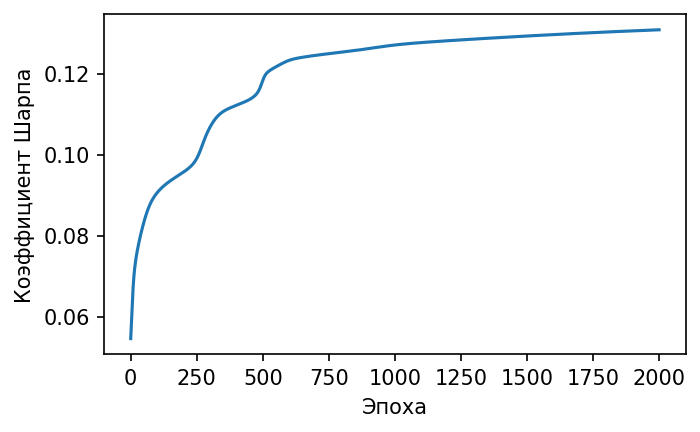

In [17]:
plt.plot(sharpes)
plt.xlabel('Эпоха')
plt.ylabel('Коэффициент Шарпа');

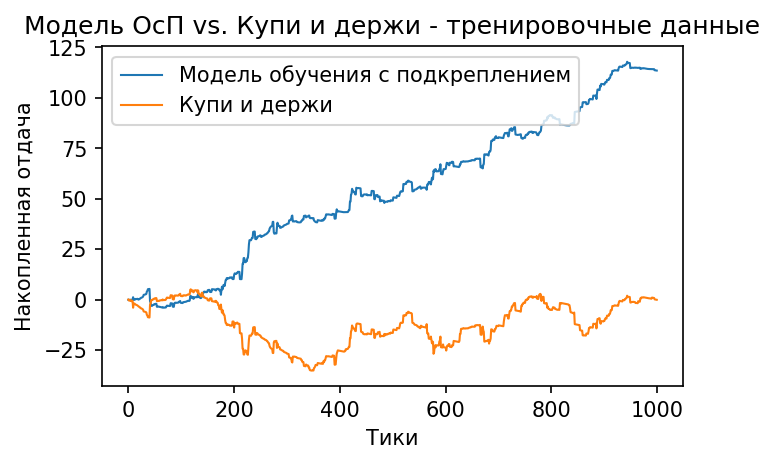

In [20]:
train_returns = returns(positions(x_train, beta), x_train, 0.0025)
plt.plot((train_returns).cumsum(), label="Модель обучения с подкреплением", linewidth=1)
plt.plot(x_train.cumsum(), label="Купи и держи", linewidth=1)
plt.xlabel('Тики')
plt.ylabel('Накопленная отдача');
plt.legend()
plt.title("Модель ОсП vs. Купи и держи - тренировочные данные");

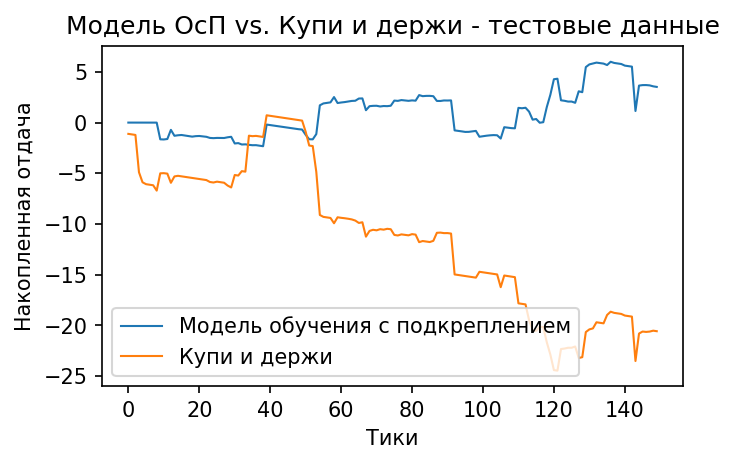

In [21]:
test_returns = returns(positions(x_test, beta), x_test, 0.0025)
plt.plot((test_returns).cumsum(), label="Модель обучения с подкреплением", linewidth=1)
plt.plot(x_test.cumsum(), label="Купи и держи", linewidth=1)
plt.xlabel('Тики')
plt.ylabel('Накопленная отдача');
plt.legend()
plt.title("Модель ОсП vs. Купи и держи - тестовые данные");